In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
import re

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from main import get_last_data_path
data_dir = "data"
data_path = get_last_data_path(data_dir)

with open(data_path, "rb") as f:
    data = pickle.load(f)

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from consts import GEMMA_2
gemma_2_data = data[GEMMA_2]

In [4]:
class_names = ['vector', 'mlp', 'attn', 'resid']
name_mapping = {'vector': 0, 'mlp': 1, 'attn': 2}#, 'resid': 3}
all_vectors = []
mlp_vs_attn = []

for steering_vector, per_vector_data in gemma_2_data.items():
    current_vectors = []
    current_mlp_vs_attn = []

    vec = per_vector_data['meta']['direction']
    current_vectors.append(vec.float())
    current_mlp_vs_attn.append(name_mapping['vector'])
    data_at_position = per_vector_data['all']
    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train, negative_norms_train, negative_agg_train = negative_outputs_train
    positive_dots_train, positive_norms_train, positive_agg_train = positive_outputs_train

    for component_name in negative_agg_train.keys():
        diff_means = positive_agg_train[component_name] - negative_agg_train[component_name]

        if 'ln2' in component_name:
            current_mlp_vs_attn.append(name_mapping['mlp'])
            current_vectors.append(diff_means.float())

        elif 'ln1' in component_name:
            current_mlp_vs_attn.append(name_mapping['attn'])
            current_vectors.append(diff_means.float())

    current_vectors = np.array(current_vectors)
    all_vectors.append(current_vectors)
    mlp_vs_attn.append(current_mlp_vs_attn)

all_vectors = np.array(all_vectors)
all_vectors = all_vectors.transpose(1,0,2)
per_steering_vector = all_vectors.copy()
all_vectors = all_vectors.reshape(all_vectors.shape[0], -1)

mlp_vs_attn = np.array(mlp_vs_attn)[0]

In [5]:
def run_tsne_umap(vectors, is_cosine=True):
    print("Running t-SNE...")
    if is_cosine:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42, metric='cosine')
    else:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    X_tsne = tsne.fit_transform(vectors)

    print("\nRunning UMAP...")
    if is_cosine:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    else:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(vectors)

    return X_tsne, X_umap

In [6]:
def create_graph(X, tsne=False, id=None):
    plt.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.figsize": (10, 7),
    })

    method_name = 't-SNE' if tsne else 'UMAP'

    _, ax = plt.subplots()

    colors = ['#E41A1C',  # Red
              '#56B4E9',  # Blue
              '#006400']  # Green

    markers = ['o', 's', '^', 'D']  # Circle, square, triangle, diamond

    for i, cls in enumerate(np.unique(mlp_vs_attn)):
        mask = mlp_vs_attn == cls
        ax.scatter(
            X[mask, 0], X[mask, 1],
            color=colors[i], marker=markers[i],
            alpha=0.85, label=class_names[i], edgecolor='black', linewidth=0.4
        )
    ax.set_title(f'{method_name} Visualization')
    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(frameon=True)

    plt.suptitle(f'{method_name}: Steering Vector Components', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save ACL-ready vector file
    plt.savefig(f"{method_name}_acl_{id if id else ''}.pdf", bbox_inches="tight")

    plt.show()

Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


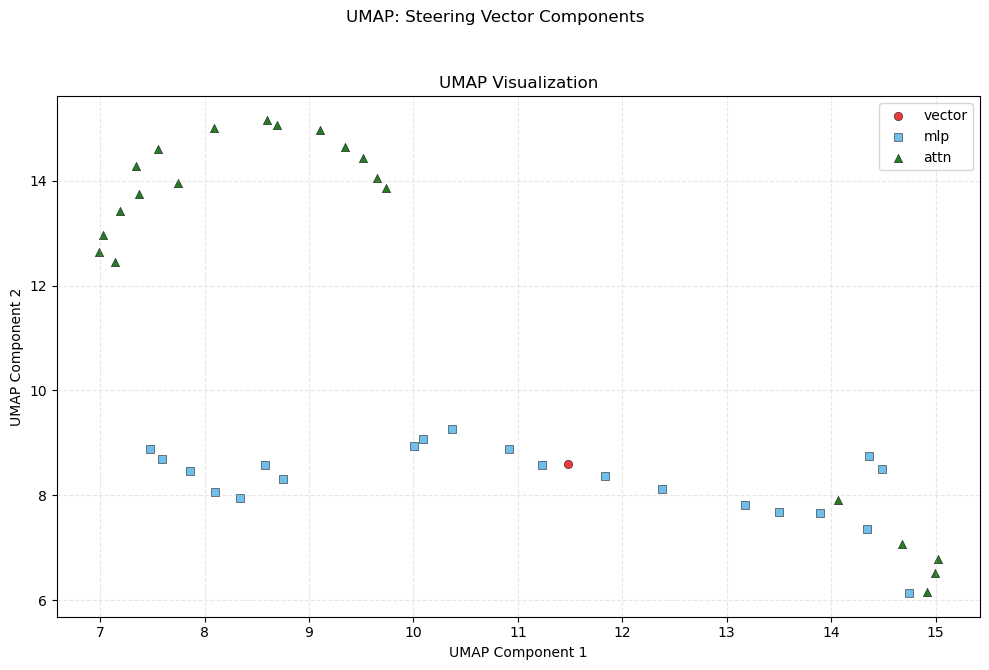

In [7]:
# RUN FOR COSINE SIMILARITY
X_tsne, X_umap = run_tsne_umap(all_vectors)
create_graph(X_umap)

Running t-SNE...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


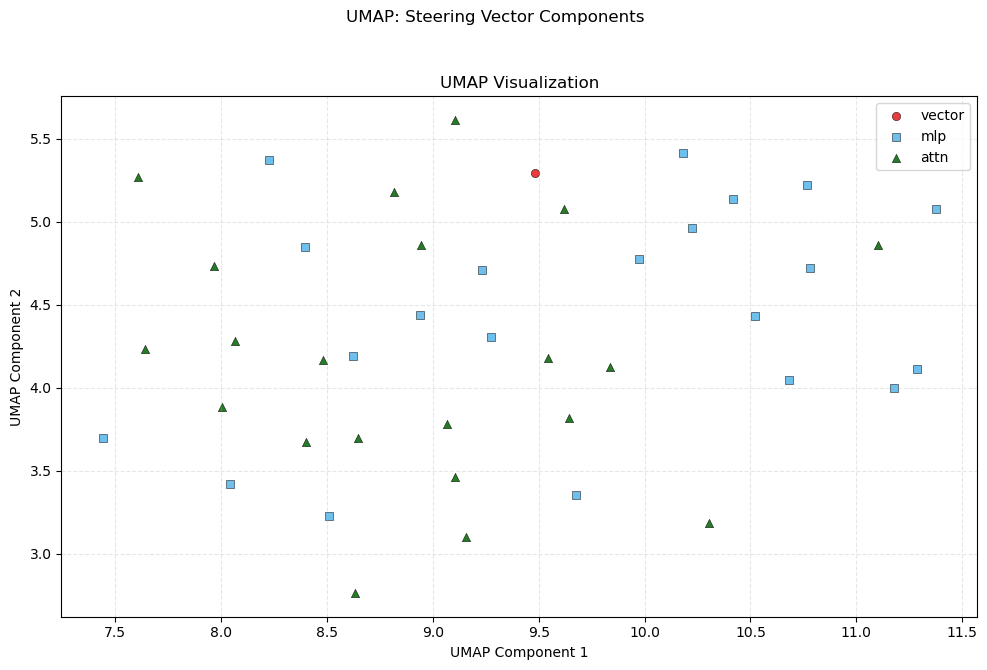

In [8]:
# RUN FOR EUCLIDEAN DISTANCE
X_tsne, X_umap = run_tsne_umap(all_vectors,is_cosine=False)
create_graph(X_umap)

1161
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


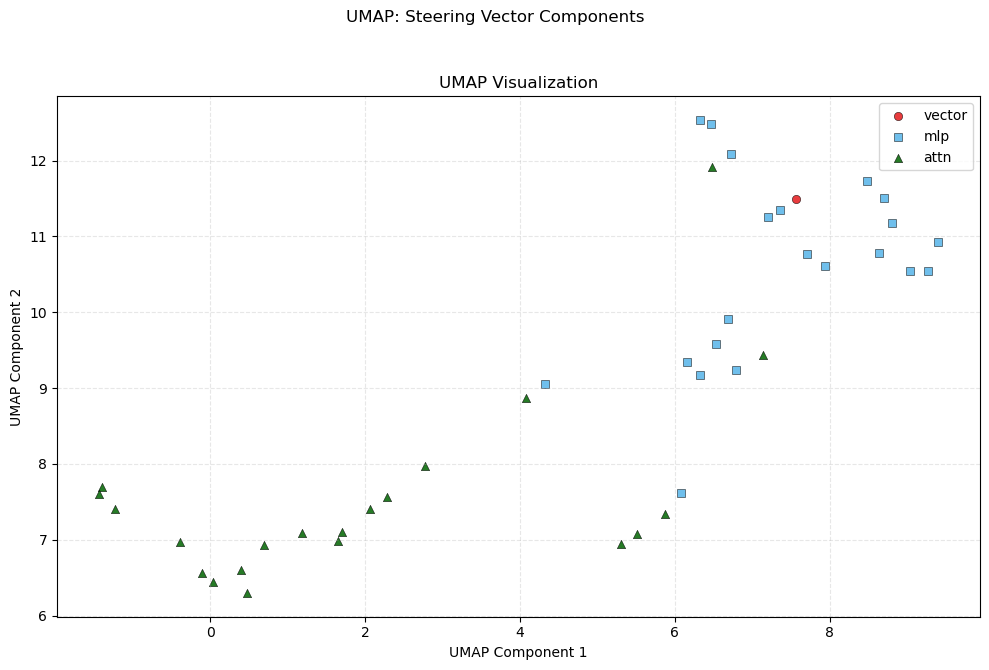

[[ 7.1441507   9.43467   ]
 [ 5.8796763   7.3340554 ]
 [ 5.5145006   7.073113  ]
 [ 5.3077188   6.936901  ]
 [ 4.076814    8.868328  ]
 [ 1.6554495   6.978232  ]
 [ 2.2904258   7.5662684 ]
 [ 2.060212    7.407701  ]
 [ 0.03348536  6.4420443 ]
 [ 1.7057099   7.1062684 ]
 [ 0.40259403  6.6063294 ]
 [ 1.1811228   7.090119  ]
 [-1.3993663   7.693886  ]
 [ 0.6954364   6.9331946 ]
 [-1.434811    7.5990644 ]
 [ 2.773912    7.96988   ]
 [ 0.4807726   6.296363  ]
 [-1.2236652   7.4091487 ]
 [-0.0997997   6.5646396 ]
 [ 6.4821253  11.921389  ]
 [-0.38976195  6.9698977 ]]
1200
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


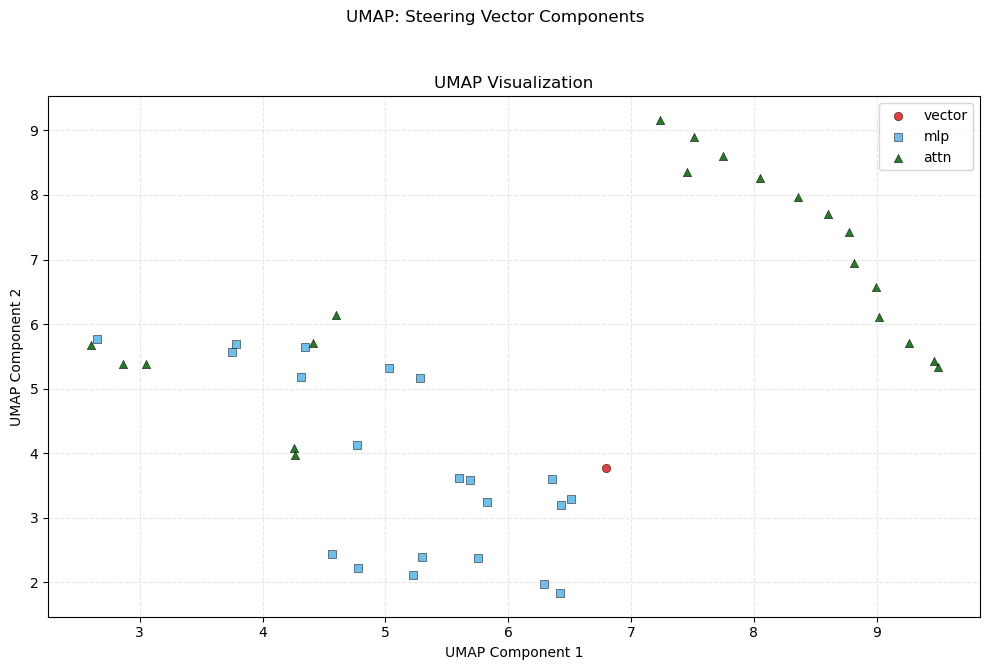

[[4.4107757 5.710663 ]
 [3.0497699 5.3821177]
 [2.8634722 5.388555 ]
 [4.597907  6.136151 ]
 [2.5981333 5.6698623]
 [7.4562206 8.353922 ]
 [7.2336416 9.160863 ]
 [7.515349  8.892887 ]
 [8.778652  7.431749 ]
 [7.7528195 8.602545 ]
 [8.600937  7.7065315]
 [8.046812  8.26425  ]
 [9.496882  5.338555 ]
 [8.3589325 7.970419 ]
 [9.467828  5.4297233]
 [4.255622  4.0745077]
 [8.813687  6.9508195]
 [9.265054  5.713252 ]
 [8.992171  6.5812635]
 [4.265182  3.9793065]
 [9.020012  6.1092052]]
137
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


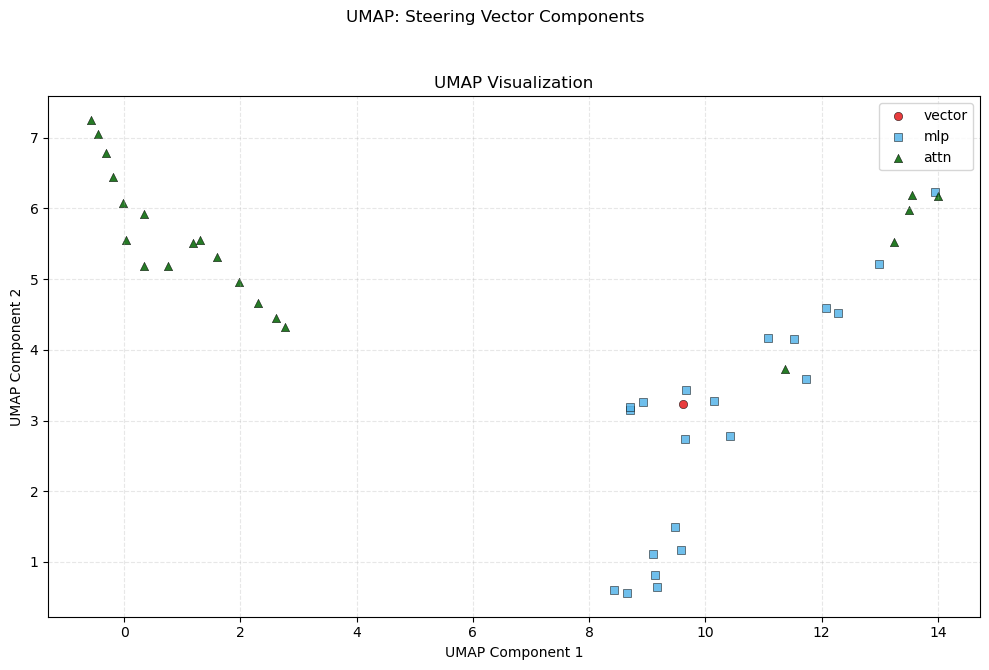

[[11.364401    3.72285   ]
 [13.553571    6.1914444 ]
 [13.506214    5.9737024 ]
 [13.995318    6.17284   ]
 [13.249585    5.5192447 ]
 [ 1.3097385   5.552688  ]
 [ 2.2962472   4.663941  ]
 [ 1.9740361   4.956497  ]
 [ 0.02616788  5.557838  ]
 [ 1.5940297   5.318101  ]
 [ 0.33792275  5.1904106 ]
 [ 1.1808505   5.507839  ]
 [-0.57751024  7.2497053 ]
 [ 0.76265055  5.1823344 ]
 [-0.44090572  7.056309  ]
 [ 2.6207645   4.4450765 ]
 [ 0.33504346  5.918889  ]
 [-0.30327803  6.776358  ]
 [-0.02650331  6.075098  ]
 [ 2.7661698   4.322462  ]
 [-0.19870579  6.4449377 ]]
3949
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


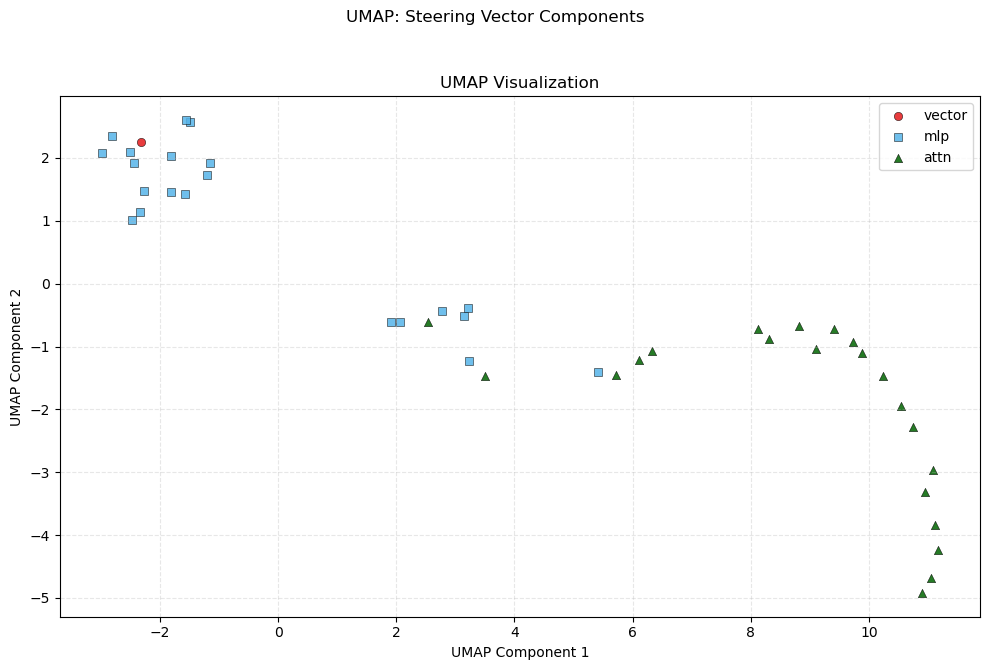

[[ 2.530842  -0.6090188]
 [ 6.326379  -1.0687914]
 [ 6.1016903 -1.2201493]
 [ 3.5041213 -1.4690125]
 [ 5.7182446 -1.4455913]
 [ 9.736588  -0.9223088]
 [ 9.1020975 -1.0465698]
 [ 8.824302  -0.6809582]
 [10.739464  -2.2878916]
 [ 9.412479  -0.7165314]
 [10.551602  -1.9475244]
 [ 9.87765   -1.1044456]
 [10.897023  -4.9234247]
 [10.232053  -1.4662957]
 [11.060561  -4.6855264]
 [ 8.314249  -0.8844337]
 [11.083298  -2.957607 ]
 [11.173619  -4.231262 ]
 [10.95858   -3.3121083]
 [ 8.12185   -0.7230246]
 [11.119134  -3.8414733]]
4086
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


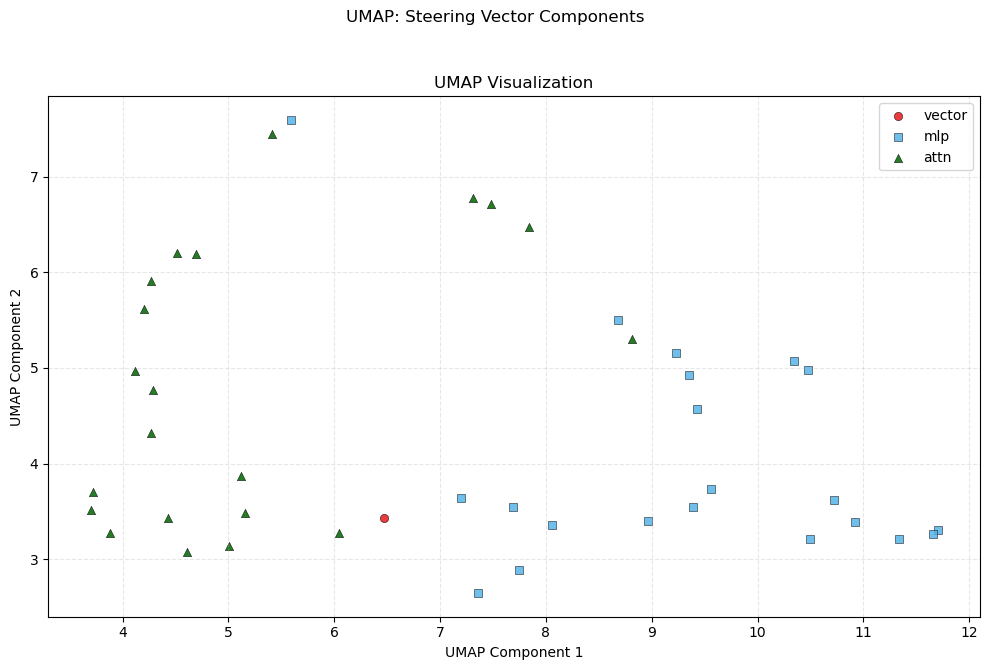

[[8.816103  5.3019114]
 [7.8378587 6.476926 ]
 [7.478203  6.7123404]
 [7.3089156 6.7815876]
 [5.416072  7.448835 ]
 [4.2904224 4.764947 ]
 [4.265398  5.9049315]
 [4.2067904 5.613138 ]
 [5.0054584 3.1394663]
 [4.121135  4.9702005]
 [5.160672  3.4846432]
 [4.264054  4.3163447]
 [3.7164    3.7004755]
 [5.119434  3.8657877]
 [3.6966035 3.5119145]
 [4.517088  6.2043505]
 [4.4298496 3.4326568]
 [3.8822615 3.2728524]
 [4.6126175 3.0776796]
 [4.693972  6.1955643]
 [6.0422063 3.2700655]]
4287
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


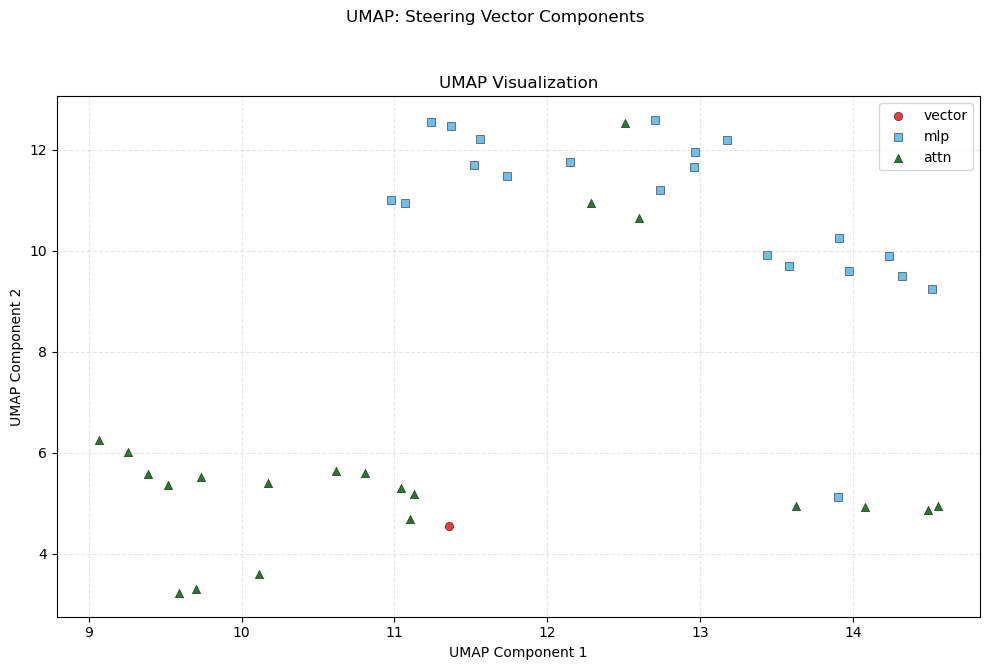

[[13.62459    4.939675 ]
 [14.554397   4.9460983]
 [14.4896965  4.8705397]
 [14.075923   4.9160104]
 [12.505587  12.529768 ]
 [ 9.517673   5.364132 ]
 [ 9.067897   6.245975 ]
 [ 9.258361   6.0129633]
 [10.807822   5.5960546]
 [ 9.39055    5.5847306]
 [10.616083   5.640124 ]
 [ 9.733295   5.521772 ]
 [ 9.591921   3.22099  ]
 [10.172347   5.402166 ]
 [ 9.705219   3.2964833]
 [12.599922  10.64875  ]
 [11.040162   5.304689 ]
 [10.112677   3.6049523]
 [11.129414   5.1867   ]
 [12.287657  10.935627 ]
 [11.101168   4.687619 ]]
5548
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


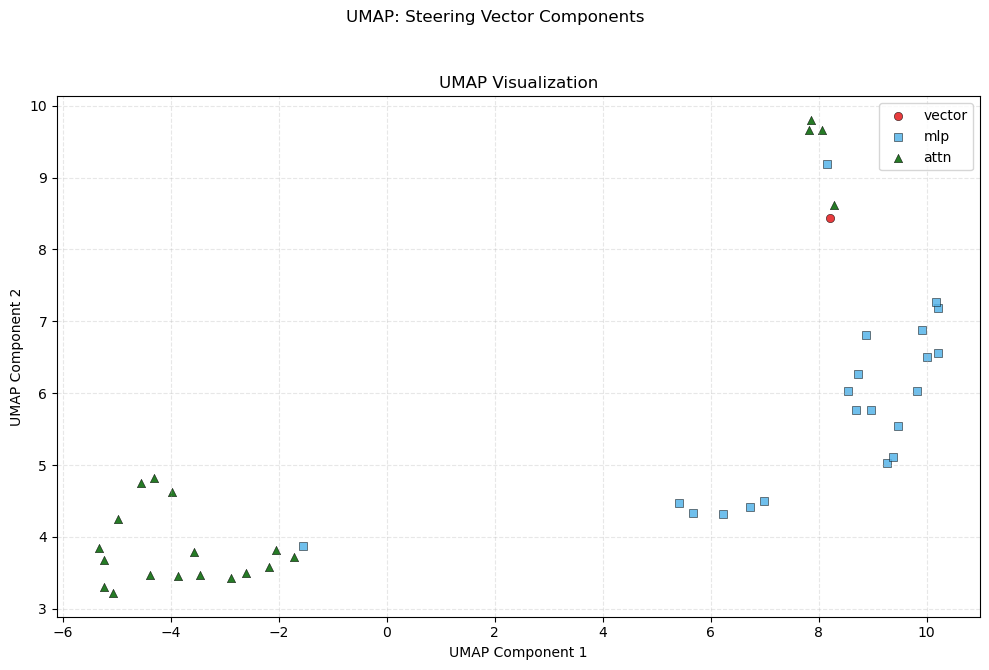

[[ 8.290862   8.614436 ]
 [ 7.81682    9.657159 ]
 [ 7.8591576  9.800177 ]
 [ 8.064097   9.657193 ]
 [-1.7291842  3.719566 ]
 [-3.582848   3.792325 ]
 [-2.6067533  3.4919732]
 [-2.8806133  3.4221723]
 [-5.2445292  3.2993846]
 [-3.4623253  3.46588  ]
 [-5.083706   3.2185671]
 [-3.8700414  3.4491675]
 [-3.9792786  4.6187367]
 [-4.3923936  3.474973 ]
 [-4.3193665  4.8227825]
 [-2.0463645  3.8214545]
 [-5.2490654  3.684402 ]
 [-4.5562162  4.7453976]
 [-5.3351393  3.8460104]
 [-2.1810899  3.5746827]
 [-4.9772105  4.2456217]]
6832
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


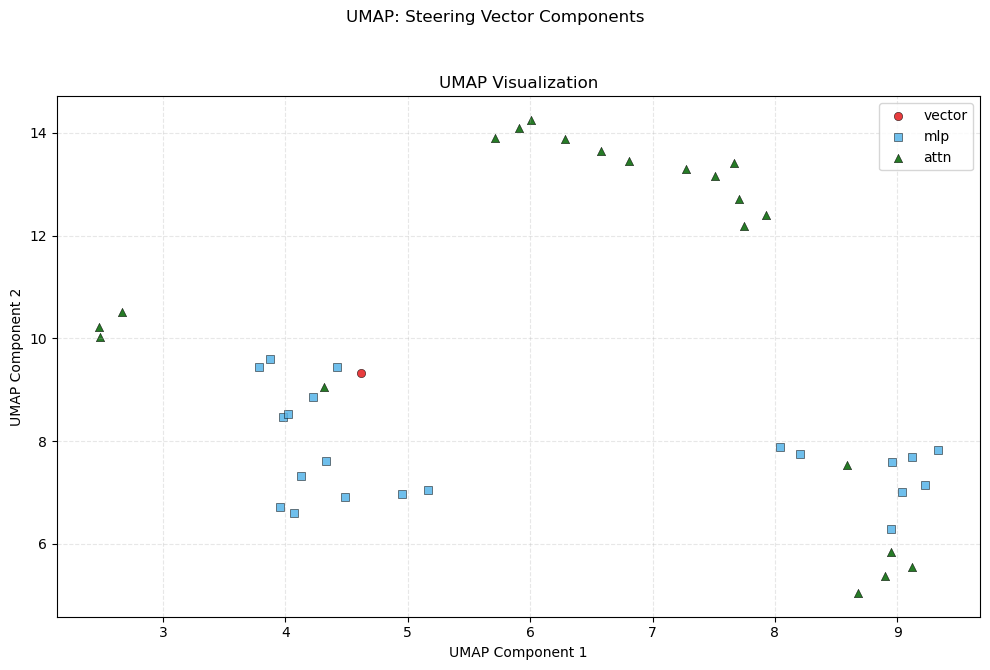

[[ 8.590689   7.5353575]
 [ 9.1246805  5.559218 ]
 [ 8.901417   5.3745127]
 [ 8.68366    5.0423923]
 [ 8.950389   5.850952 ]
 [ 7.667417  13.419457 ]
 [ 7.9257865 12.401205 ]
 [ 7.7089844 12.719135 ]
 [ 6.2884665 13.880898 ]
 [ 7.5071983 13.160125 ]
 [ 6.581384  13.6469755]
 [ 7.2732086 13.300788 ]
 [ 2.4845698 10.028334 ]
 [ 6.805472  13.44695  ]
 [ 2.4757767 10.223823 ]
 [ 7.749726  12.183969 ]
 [ 6.010797  14.251497 ]
 [ 2.6634927 10.50839  ]
 [ 5.9092994 14.100958 ]
 [ 4.3178926  9.049874 ]
 [ 5.7131705 13.900949 ]]
695
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


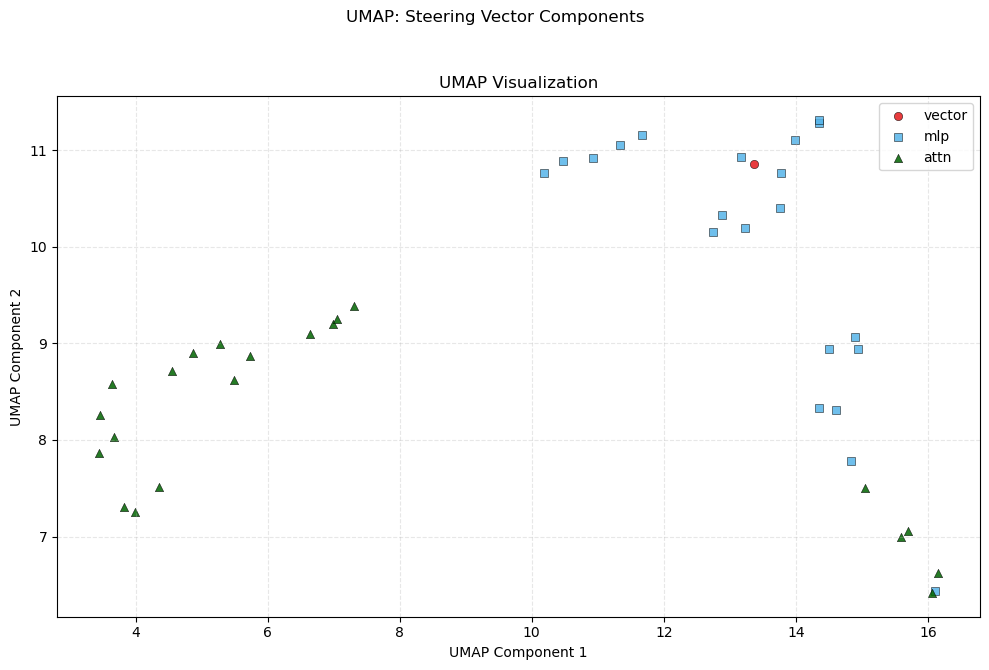

[[16.064585   6.414901 ]
 [16.152872   6.623877 ]
 [15.699621   7.0552177]
 [15.598268   6.99397  ]
 [15.040075   7.5004964]
 [ 5.494446   8.617519 ]
 [ 6.989407   9.20089  ]
 [ 6.6388445  9.098192 ]
 [ 3.6729245  8.028434 ]
 [ 5.727045   8.866145 ]
 [ 4.550801   8.71551  ]
 [ 5.2735186  8.991061 ]
 [ 4.3544183  7.514191 ]
 [ 4.871925   8.902989 ]
 [ 3.9860878  7.249967 ]
 [ 7.0537972  9.248757 ]
 [ 3.6380239  8.573684 ]
 [ 3.8252873  7.3047795]
 [ 3.468037   8.257819 ]
 [ 7.312077   9.382481 ]
 [ 3.4459195  7.865895 ]]
709
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


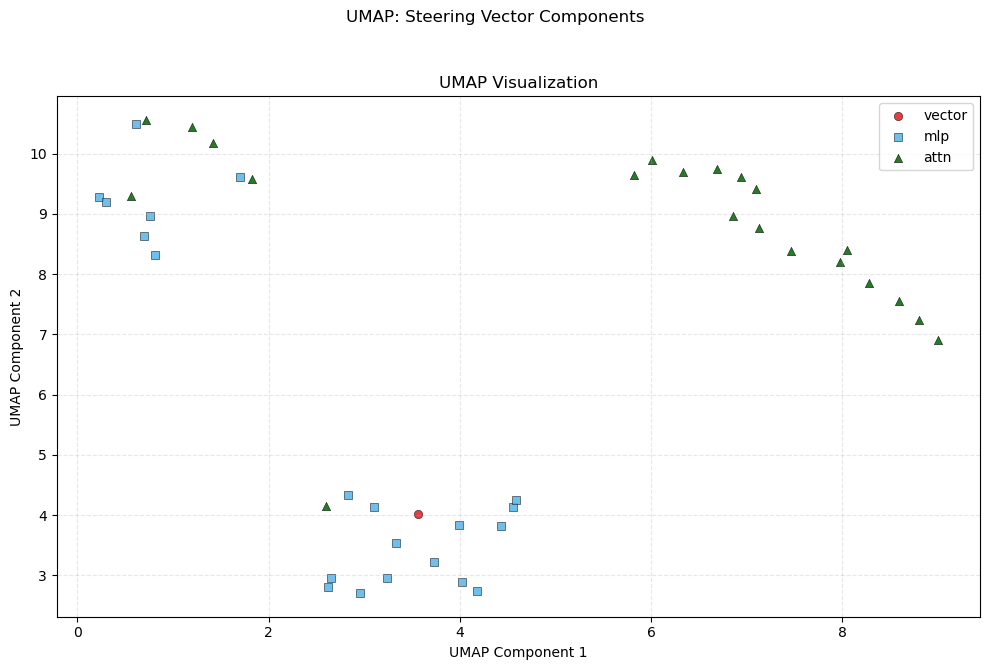

[[ 0.56485575  9.300712  ]
 [ 1.4200993  10.170157  ]
 [ 1.2021993  10.450271  ]
 [ 1.8262975   9.571862  ]
 [ 0.7199222  10.559097  ]
 [ 7.093341    9.413295  ]
 [ 6.007479    9.897392  ]
 [ 6.332471    9.704038  ]
 [ 7.4614854   8.3836775 ]
 [ 6.6892467   9.738995  ]
 [ 7.1296277   8.773782  ]
 [ 6.9365597   9.619335  ]
 [ 9.000224    6.915917  ]
 [ 6.859503    8.969229  ]
 [ 8.804924    7.2370186 ]
 [ 5.8207746   9.641712  ]
 [ 8.051197    8.407212  ]
 [ 8.590746    7.5483737 ]
 [ 7.9791512   8.201622  ]
 [ 2.5988379   4.1576214 ]
 [ 8.27764     7.850262  ]]
7988
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


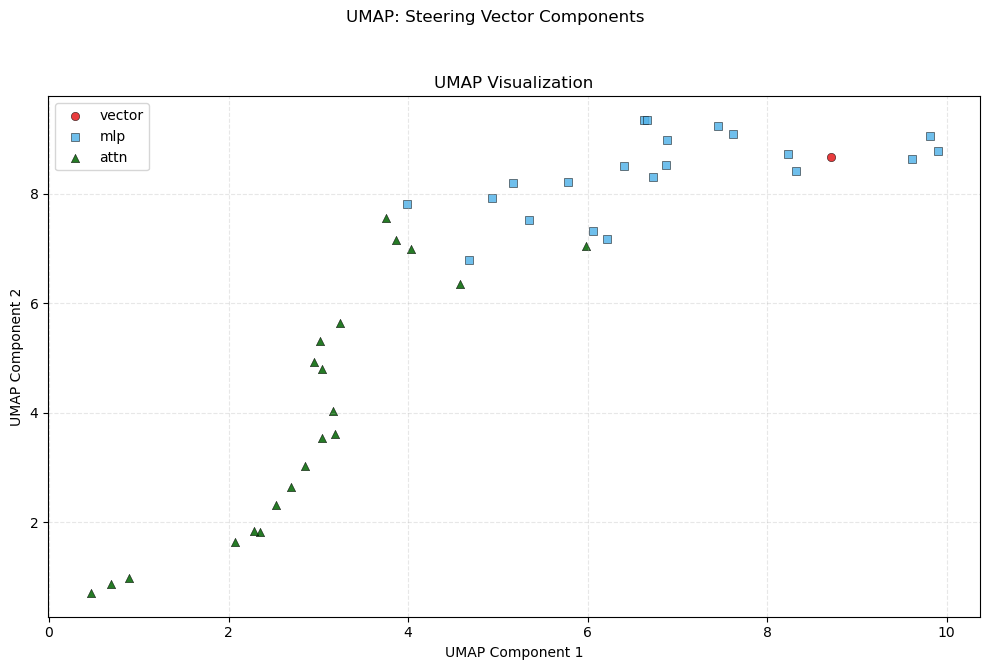

[[5.9853606  7.0386004 ]
 [4.031429   6.981213  ]
 [3.8685863  7.1489325 ]
 [4.577932   6.3532634 ]
 [3.7583108  7.5479646 ]
 [3.185072   3.6113708 ]
 [2.9532995  4.925279  ]
 [3.0362322  4.79559   ]
 [2.5285528  2.3217182 ]
 [3.1631682  4.0274014 ]
 [2.7000852  2.6426175 ]
 [3.0425704  3.5446196 ]
 [0.46239197 0.7072271 ]
 [2.8550975  3.0309591 ]
 [0.6883151  0.8801193 ]
 [3.0203397  5.30116   ]
 [2.3483565  1.8155618 ]
 [0.8913305  0.9870476 ]
 [2.2888274  1.8370706 ]
 [3.2477772  5.640634  ]
 [2.0703254  1.6438358 ]]
8015
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


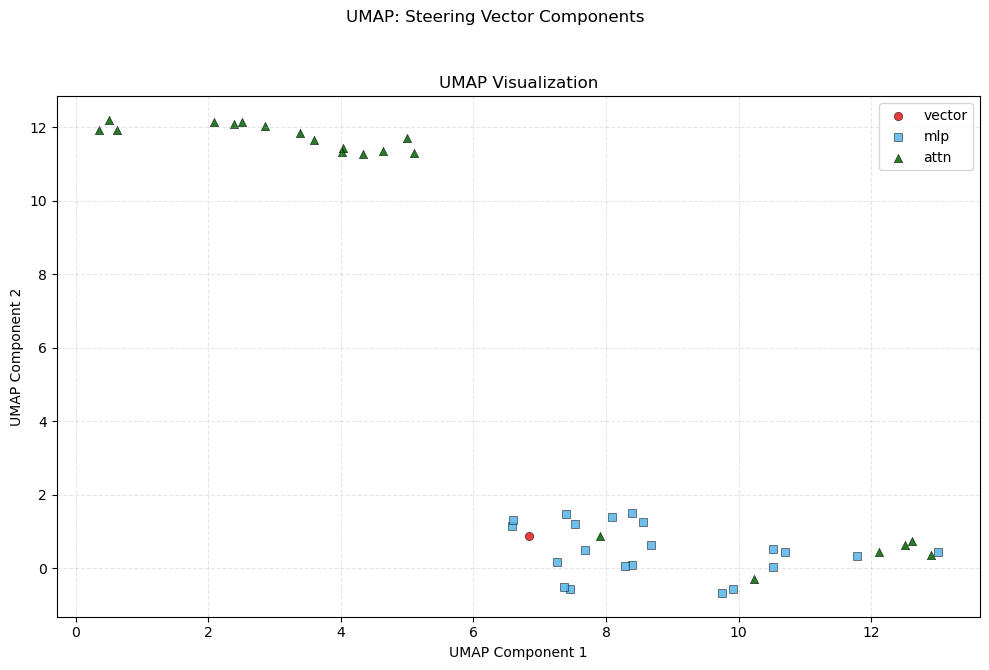

[[10.236739   -0.30226853]
 [12.6108265   0.73549235]
 [12.503708    0.629533  ]
 [12.893061    0.3545457 ]
 [12.11237     0.45657775]
 [ 4.0280995  11.443211  ]
 [ 4.990336   11.719471  ]
 [ 4.633568   11.362556  ]
 [ 2.8597524  12.039406  ]
 [ 4.3302097  11.265046  ]
 [ 3.38766    11.841513  ]
 [ 4.0156975  11.329148  ]
 [ 0.62915653 11.920685  ]
 [ 3.58892    11.649362  ]
 [ 0.3534029  11.917732  ]
 [ 5.096078   11.303894  ]
 [ 2.5104723  12.161899  ]
 [ 0.50946707 12.203811  ]
 [ 2.3952928  12.10572   ]
 [ 7.9122157   0.88585794]
 [ 2.0813847  12.15838   ]]
1201
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


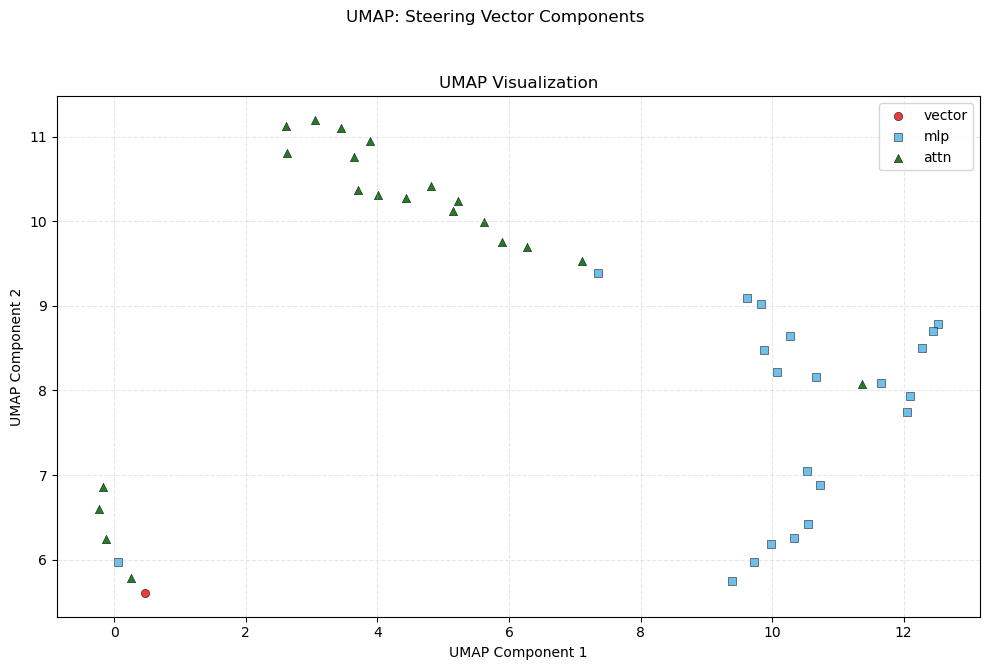

[[ 0.25460047  5.786198  ]
 [-0.11828967  6.2393427 ]
 [-0.23137262  6.5992494 ]
 [-0.16884318  6.862048  ]
 [ 7.106624    9.533713  ]
 [ 5.146683   10.123839  ]
 [ 5.8932323   9.759767  ]
 [ 5.617522    9.98687   ]
 [ 3.7034879  10.371412  ]
 [ 5.2318125  10.239175  ]
 [ 4.0027733  10.306934  ]
 [ 4.8190026  10.418856  ]
 [ 2.6318173  10.80771   ]
 [ 4.4422054  10.277659  ]
 [ 2.6046183  11.12486   ]
 [ 6.2726245   9.693181  ]
 [ 3.8805935  10.953989  ]
 [ 3.0553002  11.196445  ]
 [ 3.6476035  10.76453   ]
 [11.362381    8.079242  ]
 [ 3.442279   11.102118  ]]
1337
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


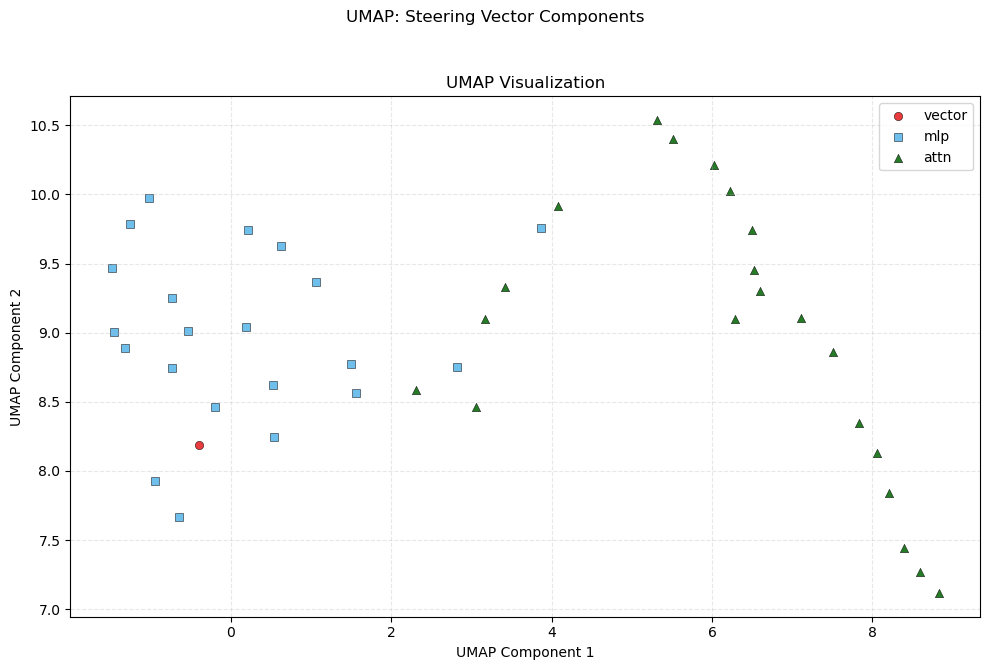

[[ 2.3127754  8.586681 ]
 [ 3.1714385  9.102244 ]
 [ 3.4181805  9.332815 ]
 [ 3.0589767  8.465927 ]
 [ 4.082532   9.916449 ]
 [ 6.286816   9.100086 ]
 [ 6.0268598 10.214596 ]
 [ 6.2252655 10.024036 ]
 [ 7.5035195  8.8615465]
 [ 6.5038624  9.74276  ]
 [ 7.106211   9.108696 ]
 [ 6.5192785  9.456105 ]
 [ 8.825353   7.116891 ]
 [ 6.5937157  9.30483  ]
 [ 8.5957155  7.2657948]
 [ 5.512322  10.401927 ]
 [ 7.8292446  8.349872 ]
 [ 8.395774   7.4449024]
 [ 8.05836    8.132933 ]
 [ 5.31391   10.5382395]
 [ 8.206373   7.838285 ]]
14
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


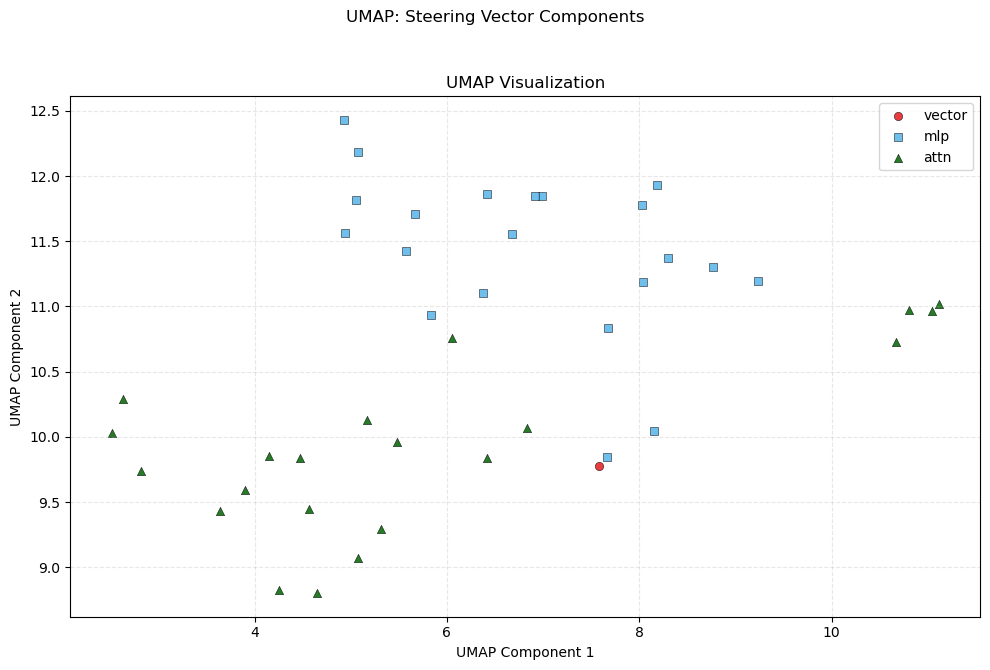

[[10.664728  10.728568 ]
 [10.801727  10.975114 ]
 [11.111322  11.017893 ]
 [11.046651  10.967541 ]
 [ 3.6422672  9.435666 ]
 [ 4.1487103  9.850212 ]
 [ 4.256611   8.829653 ]
 [ 5.3152857  9.296307 ]
 [ 2.8218305  9.74044  ]
 [ 5.0721536  9.074251 ]
 [ 3.8968837  9.595373 ]
 [ 4.5648947  9.449355 ]
 [ 4.650439   8.803341 ]
 [ 4.4756594  9.837579 ]
 [ 2.6337795 10.291476 ]
 [ 6.8317327 10.07032  ]
 [ 5.47604    9.962488 ]
 [ 2.514837  10.02956  ]
 [ 5.1718326 10.133468 ]
 [ 6.0573034 10.756837 ]
 [ 6.419789   9.838115 ]]
1555
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


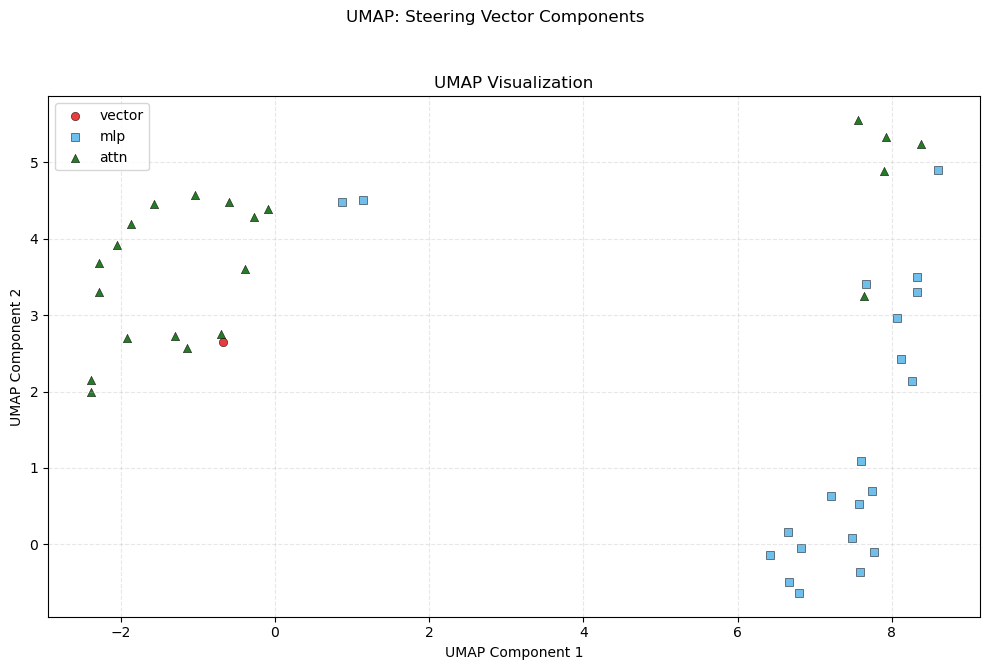

[[ 7.636916    3.2564855 ]
 [ 7.899024    4.883376  ]
 [ 7.9248705   5.340074  ]
 [ 7.562572    5.556416  ]
 [ 8.382163    5.2436366 ]
 [-1.8641586   4.1916533 ]
 [-0.598601    4.481692  ]
 [-1.0381843   4.5721593 ]
 [-1.9196233   2.6989522 ]
 [-1.5718478   4.4575586 ]
 [-2.2817683   3.3063903 ]
 [-2.0501301   3.9231277 ]
 [-2.380114    1.9898839 ]
 [-2.2799776   3.6897607 ]
 [-2.3888628   2.1528697 ]
 [-0.26289108  4.2923775 ]
 [-1.2981098   2.729628  ]
 [-0.38732404  3.6092603 ]
 [-1.1319778   2.5721502 ]
 [-0.09034115  4.388833  ]
 [-0.6942255   2.758836  ]]
1752
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


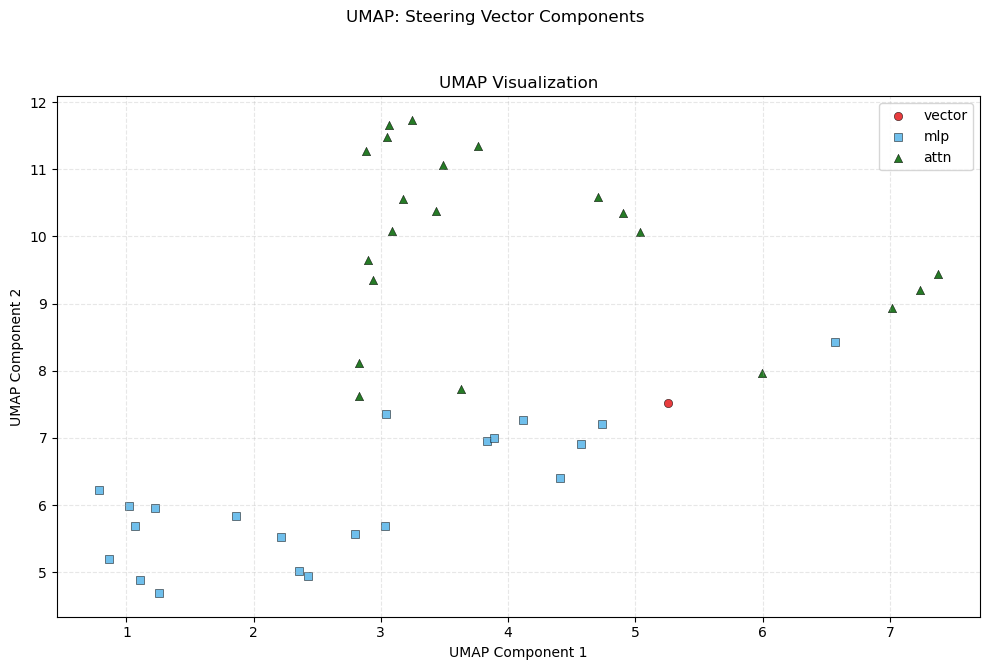

[[ 5.991893   7.96349  ]
 [ 7.020443   8.927315 ]
 [ 7.2393365  9.202684 ]
 [ 7.3790026  9.441611 ]
 [ 2.8313153  7.6227427]
 [ 3.4322977 10.375182 ]
 [ 2.9406931  9.3459835]
 [ 2.901928   9.647087 ]
 [ 3.0630925 11.654299 ]
 [ 3.086638  10.081569 ]
 [ 3.2483304 11.735099 ]
 [ 3.1768126 10.554261 ]
 [ 5.0389414 10.071282 ]
 [ 3.4849248 11.061722 ]
 [ 4.9008102 10.352808 ]
 [ 2.8314404  8.122626 ]
 [ 2.8795016 11.276891 ]
 [ 4.7086406 10.590383 ]
 [ 3.0444176 11.482763 ]
 [ 3.6293964  7.7324176]
 [ 3.7633324 11.350671 ]]
1818
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


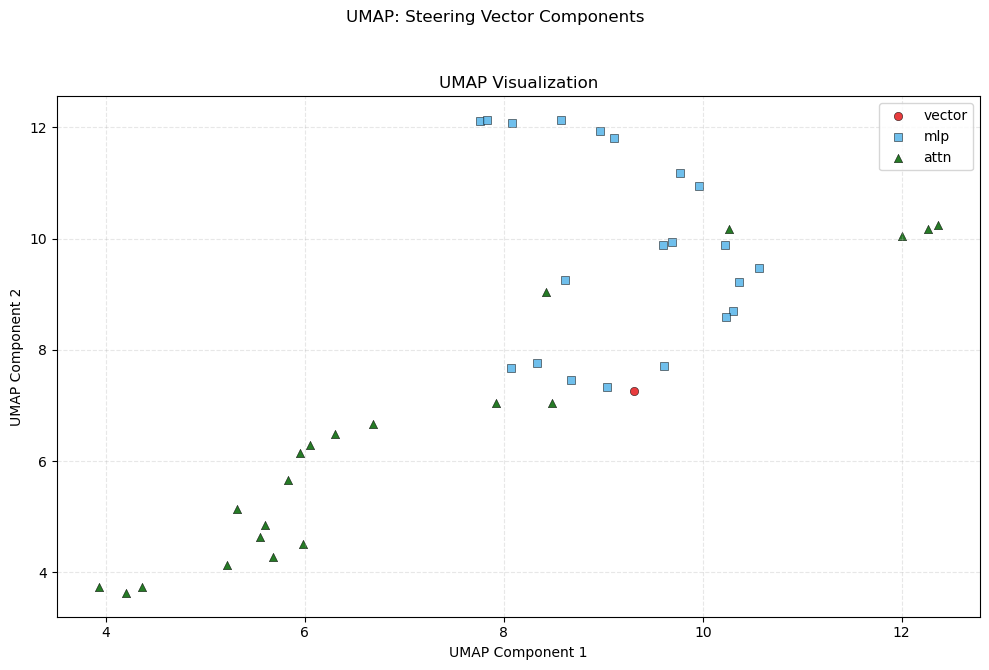

[[10.261769  10.176113 ]
 [12.364199  10.244608 ]
 [12.260202  10.165567 ]
 [11.997832  10.044417 ]
 [ 8.424772   9.036497 ]
 [ 6.05246    6.281729 ]
 [ 5.825901   5.651057 ]
 [ 6.6852956  6.6597776]
 [ 5.5504823  4.6427393]
 [ 6.301112   6.478997 ]
 [ 5.59792    4.84472  ]
 [ 5.9549236  6.141564 ]
 [ 3.9306939  3.738728 ]
 [ 5.3155026  5.1348596]
 [ 4.1999283  3.6257844]
 [ 7.9188933  7.0529757]
 [ 5.985005   4.511507 ]
 [ 4.367699   3.7353609]
 [ 5.676261   4.2766843]
 [ 8.483466   7.0422463]
 [ 5.217091   4.1314363]]
1838
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


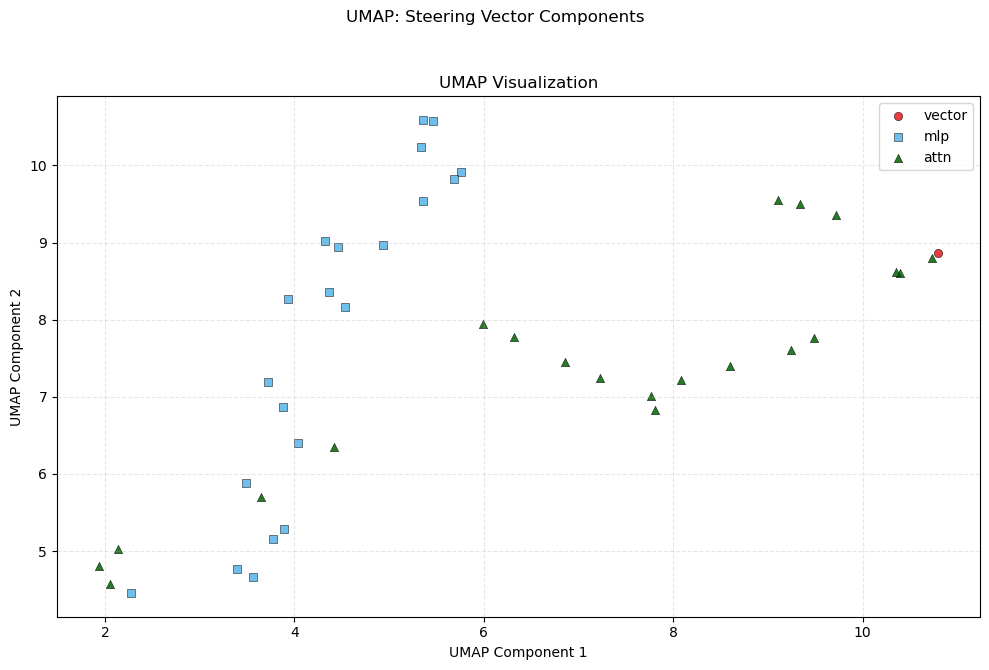

[[ 3.6498203  5.7069144]
 [ 2.1391058  5.028263 ]
 [ 1.9360726  4.801461 ]
 [ 4.4168835  6.3477335]
 [ 2.0570726  4.572555 ]
 [ 7.8063006  6.8292546]
 [ 6.853481   7.4449706]
 [ 7.231375   7.242563 ]
 [ 9.488006   7.7617354]
 [ 7.7667785  7.0063405]
 [ 9.241561   7.6083074]
 [ 8.080623   7.213257 ]
 [ 9.10732    9.556562 ]
 [ 8.597051   7.394527 ]
 [ 9.344213   9.499716 ]
 [ 6.3154783  7.7691092]
 [10.393883   8.602933 ]
 [ 9.718505   9.352976 ]
 [10.355164   8.618011 ]
 [ 5.988836   7.9438643]
 [10.730138   8.796435 ]]
205
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


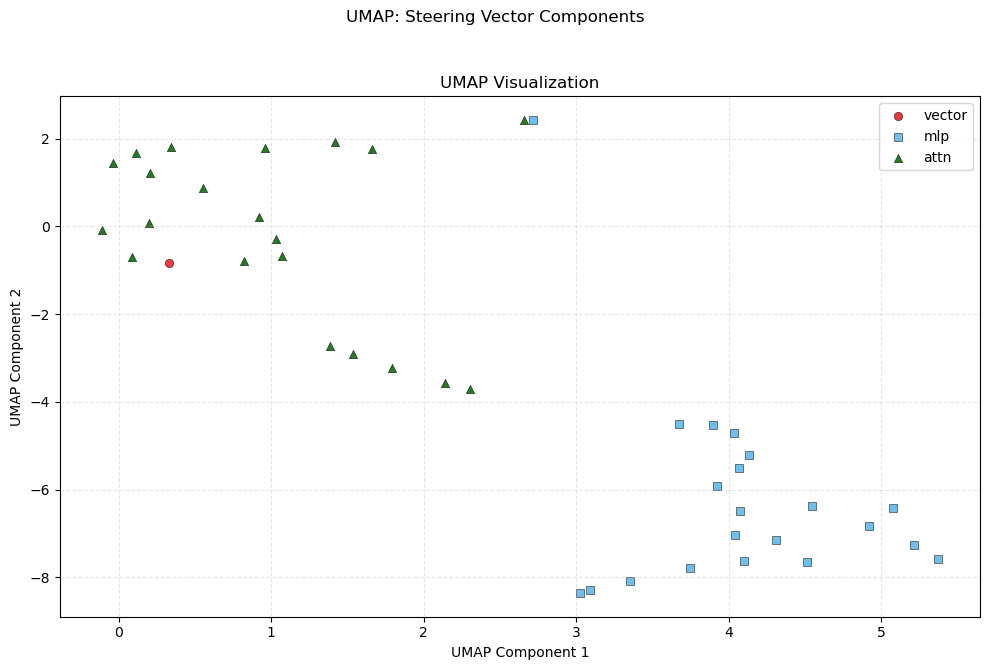

[[ 2.3018398  -3.6966012 ]
 [ 2.1373942  -3.56618   ]
 [ 1.7908288  -3.2216063 ]
 [ 2.6587238   2.419439  ]
 [ 1.5358541  -2.9074936 ]
 [ 0.20345658  1.2226908 ]
 [ 0.19737163  0.08591224]
 [ 0.9571819   1.7961489 ]
 [ 0.08961431 -0.6972004 ]
 [ 0.34536403  1.8018199 ]
 [-0.11097156 -0.08719173]
 [-0.03681765  1.4554952 ]
 [ 0.5530342   0.87366635]
 [ 0.11676539  1.6682868 ]
 [ 1.3878583  -2.7338111 ]
 [ 1.421766    1.9245005 ]
 [ 1.0726205  -0.6809565 ]
 [ 0.9180598   0.21222049]
 [ 0.82404983 -0.7951758 ]
 [ 1.6600987   1.7758659 ]
 [ 1.0325097  -0.2882613 ]]
2445
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


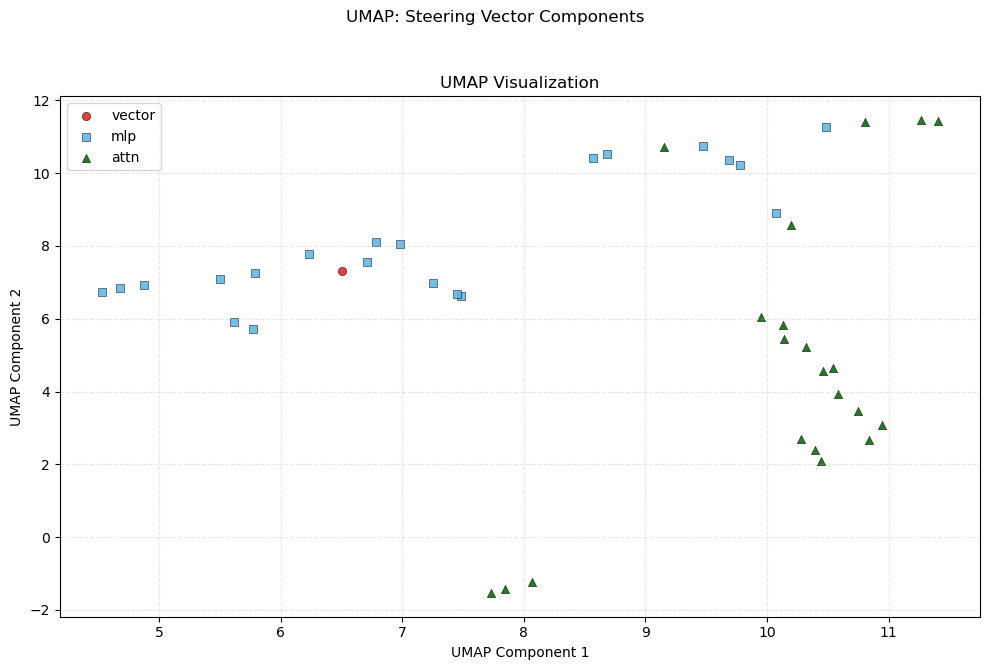

[[ 9.150183  10.712251 ]
 [10.802367  11.394968 ]
 [11.266697  11.45882  ]
 [11.4074335 11.419732 ]
 [10.19588    8.587412 ]
 [10.461246   4.5507264]
 [10.139118   5.4311285]
 [10.317428   5.2287726]
 [10.841013   2.6617172]
 [10.54572    4.6414604]
 [10.947778   3.0734904]
 [10.584575   3.9458206]
 [ 7.7267265 -1.5353994]
 [10.749521   3.4552424]
 [ 7.844539  -1.4352598]
 [10.1306715  5.8332253]
 [10.28193    2.6913261]
 [ 8.064515  -1.2268596]
 [10.393804   2.4051135]
 [ 9.951522   6.0440516]
 [10.439611   2.0875163]]
2590
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


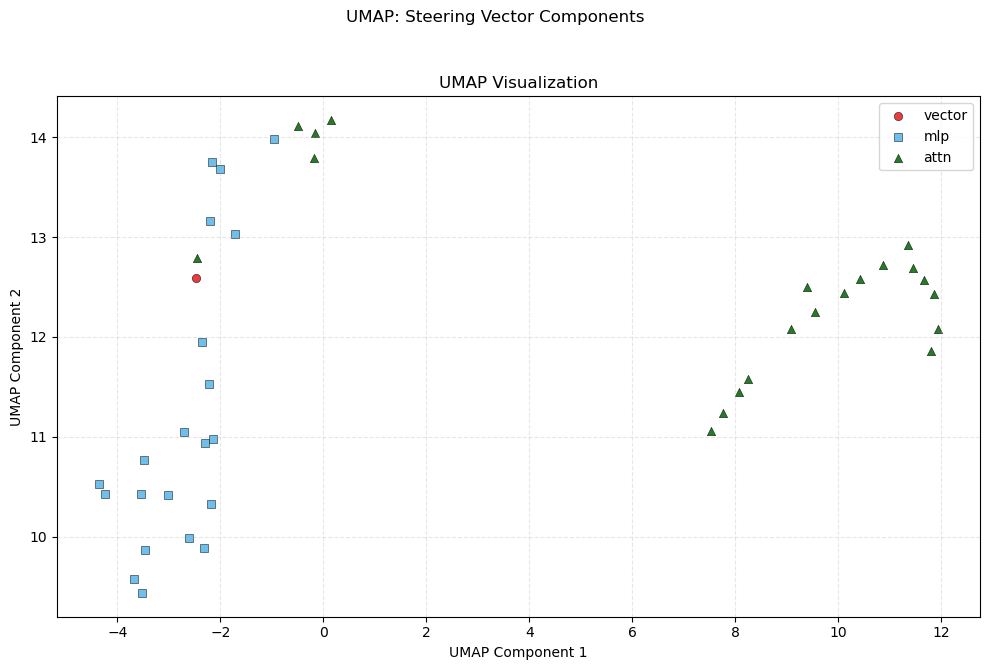

[[-2.4522688  12.792389  ]
 [-0.17930728 13.791837  ]
 [-0.16291054 14.039789  ]
 [ 0.14652565 14.171415  ]
 [-0.4885182  14.115451  ]
 [ 9.396705   12.499455  ]
 [ 8.0629835  11.449918  ]
 [ 8.239875   11.583254  ]
 [10.865702   12.719958  ]
 [ 9.079524   12.079784  ]
 [10.419666   12.579021  ]
 [ 9.554055   12.251665  ]
 [11.794066   11.859591  ]
 [10.106918   12.443991  ]
 [11.937656   12.078237  ]
 [ 7.7592015  11.241469  ]
 [11.355753   12.92208   ]
 [11.867762   12.431523  ]
 [11.457473   12.68775   ]
 [ 7.5244813  11.057552  ]
 [11.65638    12.574236  ]]
269
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


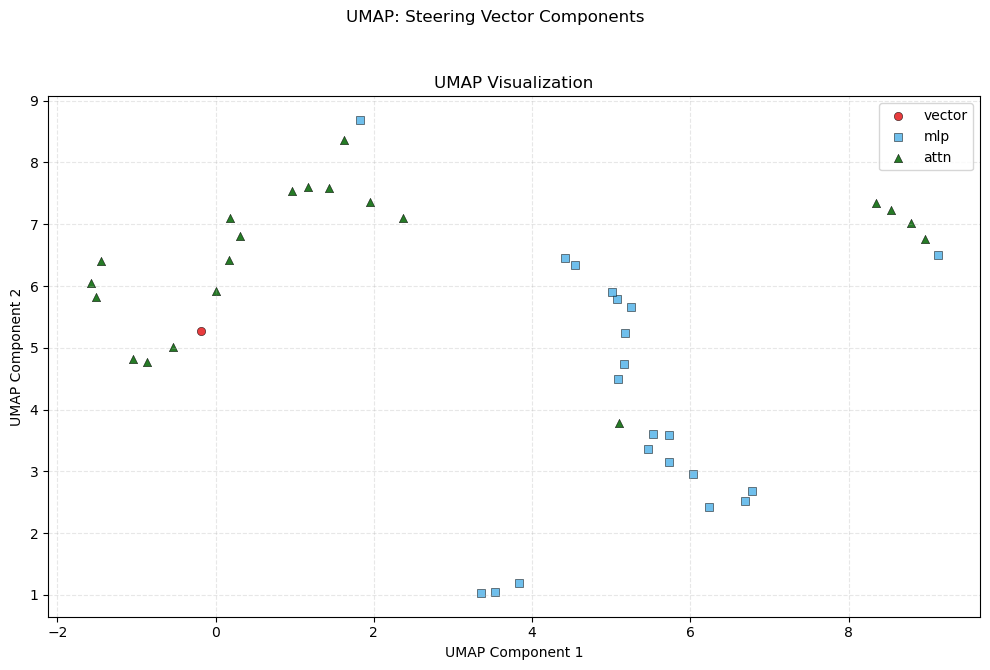

[[ 8.3509884e+00  7.3460546e+00]
 [ 8.5329704e+00  7.2349558e+00]
 [ 8.7903814e+00  7.0184369e+00]
 [ 1.6255876e+00  8.3665600e+00]
 [ 8.9703350e+00  6.7593303e+00]
 [ 1.8303606e-01  7.0932636e+00]
 [ 5.1049271e+00  3.7816923e+00]
 [ 1.4336052e+00  7.5930357e+00]
 [ 4.1984278e-03  5.9128842e+00]
 [ 1.1659653e+00  7.6056938e+00]
 [ 1.6933957e-01  6.4157767e+00]
 [ 9.6578687e-01  7.5316434e+00]
 [-1.4496444e+00  6.4033699e+00]
 [ 3.0812532e-01  6.8111401e+00]
 [-1.5802431e+00  6.0559926e+00]
 [ 1.9576602e+00  7.3545537e+00]
 [-8.6741835e-01  4.7648749e+00]
 [-1.5117103e+00  5.8253675e+00]
 [-5.4122233e-01  5.0196710e+00]
 [ 2.3693089e+00  7.1058321e+00]
 [-1.0427989e+00  4.8161769e+00]]
294
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


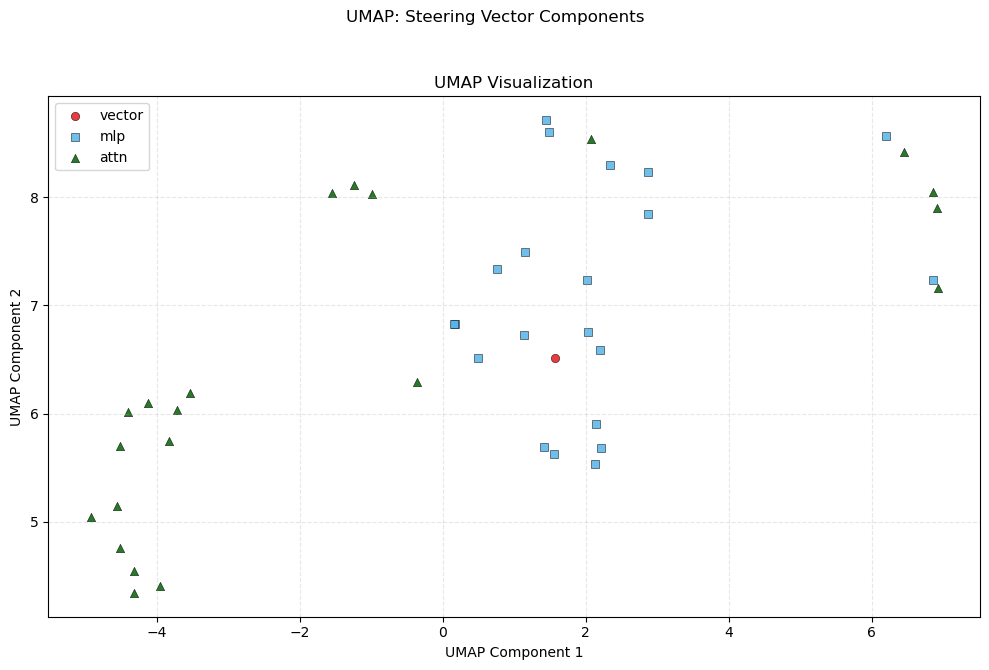

[[ 2.075592    8.541183  ]
 [ 6.913854    7.900118  ]
 [ 6.860282    8.045312  ]
 [ 6.921805    7.16456   ]
 [ 6.4475102   8.417084  ]
 [-4.9250865   5.043225  ]
 [-4.3215075   4.33971   ]
 [-4.318869    4.541306  ]
 [-4.126285    6.093577  ]
 [-4.509159    4.7583284 ]
 [-4.4059362   6.0166197 ]
 [-4.555424    5.149509  ]
 [-0.98210675  8.0311775 ]
 [-4.515468    5.696145  ]
 [-1.2433192   8.117711  ]
 [-3.9505405   4.4043183 ]
 [-3.8249395   5.7478056 ]
 [-1.5530782   8.035857  ]
 [-3.7144547   6.0300174 ]
 [-0.35553584  6.2957063 ]
 [-3.5275652   6.192247  ]]
3306
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


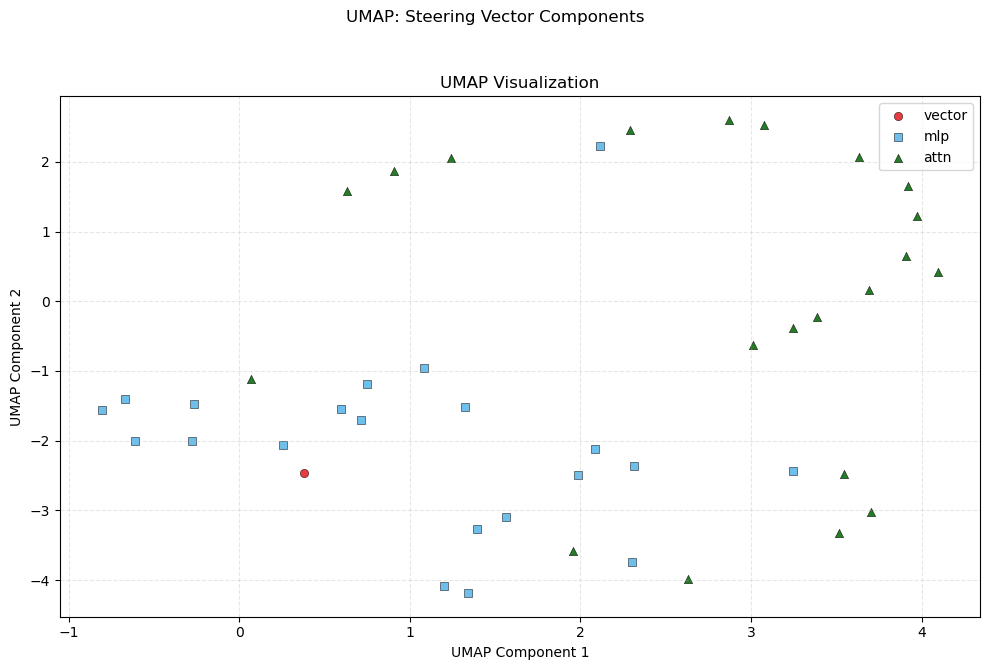

[[ 1.9577099  -3.580996  ]
 [ 3.5171497  -3.3310893 ]
 [ 3.701789   -3.0287614 ]
 [ 2.6304429  -3.9779878 ]
 [ 3.5434785  -2.4821389 ]
 [ 4.09696     0.4166975 ]
 [ 3.2464411  -0.38106236]
 [ 3.3895125  -0.22044474]
 [ 3.6331775   2.070202  ]
 [ 3.68975     0.15834257]
 [ 3.919907    1.6599507 ]
 [ 3.9107673   0.65009737]
 [ 0.63395053  1.5859193 ]
 [ 3.9747844   1.2206979 ]
 [ 0.9080411   1.8668609 ]
 [ 3.0103374  -0.6341808 ]
 [ 3.0775454   2.527936  ]
 [ 1.23996     2.0625288 ]
 [ 2.8698885   2.6009188 ]
 [ 0.06836297 -1.1085566 ]
 [ 2.2919984   2.4603946 ]]
384
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


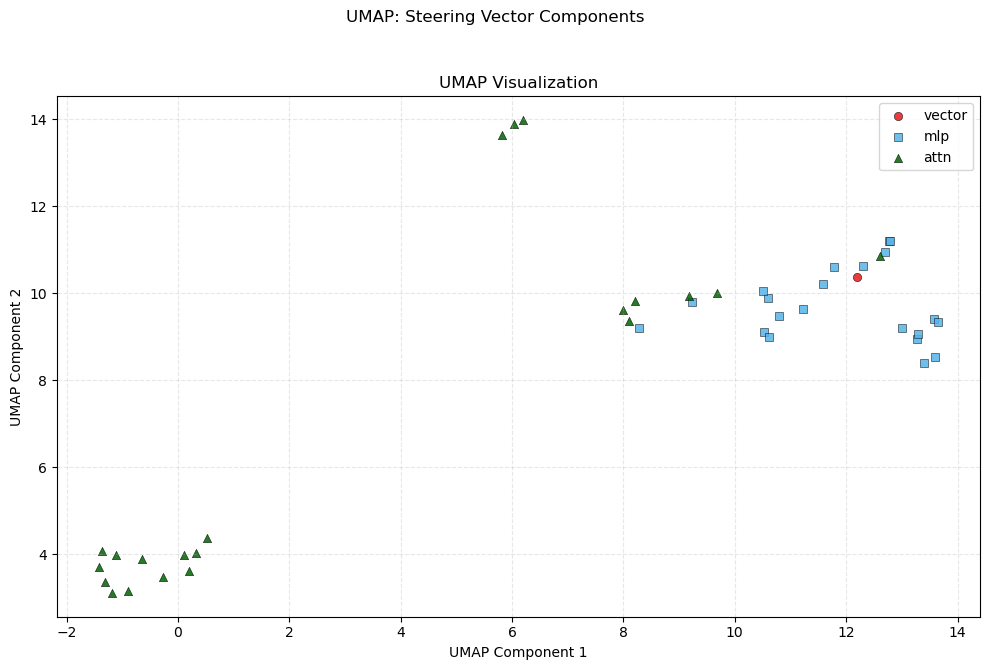

[[ 9.6734085  10.014424  ]
 [ 8.213249    9.820764  ]
 [ 7.992833    9.61408   ]
 [ 9.170934    9.934523  ]
 [ 8.100503    9.35932   ]
 [-1.358947    4.0775332 ]
 [-1.1878306   3.1040807 ]
 [-1.3108352   3.368215  ]
 [ 0.19947657  3.6216567 ]
 [-1.4187495   3.7150648 ]
 [-0.26700136  3.473738  ]
 [-1.120505    3.9687147 ]
 [ 6.2002687  13.985944  ]
 [-0.6420908   3.8896658 ]
 [ 6.039689   13.890329  ]
 [-0.90558773  3.142896  ]
 [ 0.11539941  3.985427  ]
 [ 5.8163614  13.645437  ]
 [ 0.3258385   4.021043  ]
 [12.601693   10.854065  ]
 [ 0.51486945  4.380393  ]]
541
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


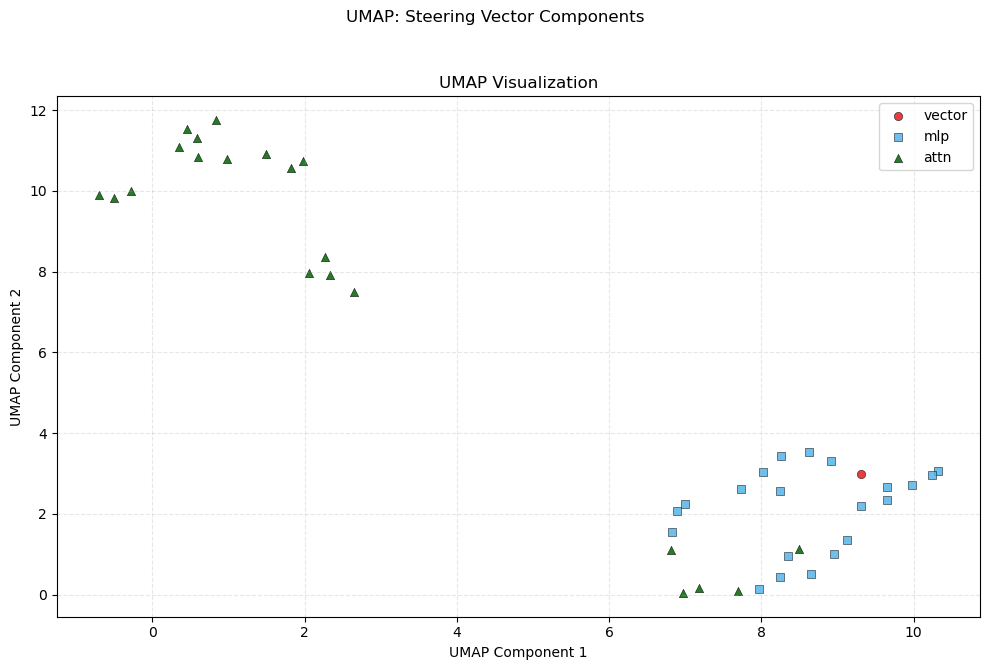

[[ 8.487818    1.1198473 ]
 [ 6.9656553   0.0363077 ]
 [ 7.1782317   0.17253928]
 [ 6.811159    1.1073705 ]
 [ 7.695829    0.08881133]
 [ 1.978618   10.738294  ]
 [ 2.0582614   7.9746604 ]
 [ 2.2683527   8.354462  ]
 [ 0.3479481  11.09173   ]
 [ 1.8182789  10.579097  ]
 [ 0.60295725 10.847425  ]
 [ 1.4942499  10.916989  ]
 [-0.27647677 10.009858  ]
 [ 0.9786519  10.787727  ]
 [-0.50162977  9.815719  ]
 [ 2.3347862   7.923608  ]
 [ 0.8368166  11.756923  ]
 [-0.6994188   9.89409   ]
 [ 0.4611554  11.537032  ]
 [ 2.6516814   7.49582   ]
 [ 0.59295374 11.306832  ]]
881
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


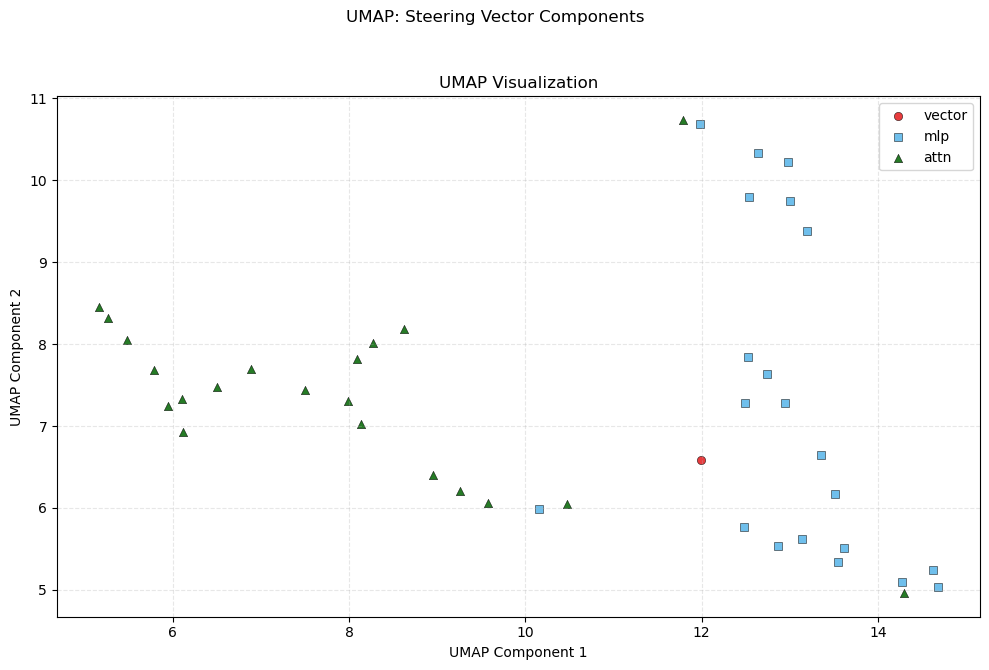

[[10.476108   6.046734 ]
 [ 9.576384   6.0559735]
 [ 9.252607   6.205803 ]
 [ 8.947396   6.406213 ]
 [11.782951  10.735566 ]
 [ 8.131274   7.029122 ]
 [ 8.267575   8.007647 ]
 [ 8.093547   7.8167343]
 [ 6.1010284  7.3268423]
 [ 7.9854765  7.308059 ]
 [ 6.4989123  7.4708195]
 [ 7.503717   7.4392595]
 [ 5.163115   8.45074  ]
 [ 6.8840137  7.6912103]
 [ 5.2696605  8.318181 ]
 [ 8.624437   8.187182 ]
 [ 6.113701   6.9289274]
 [ 5.4801445  8.055168 ]
 [ 5.9477663  7.239627 ]
 [14.28925    4.9615583]
 [ 5.79241    7.6781683]]
9154
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


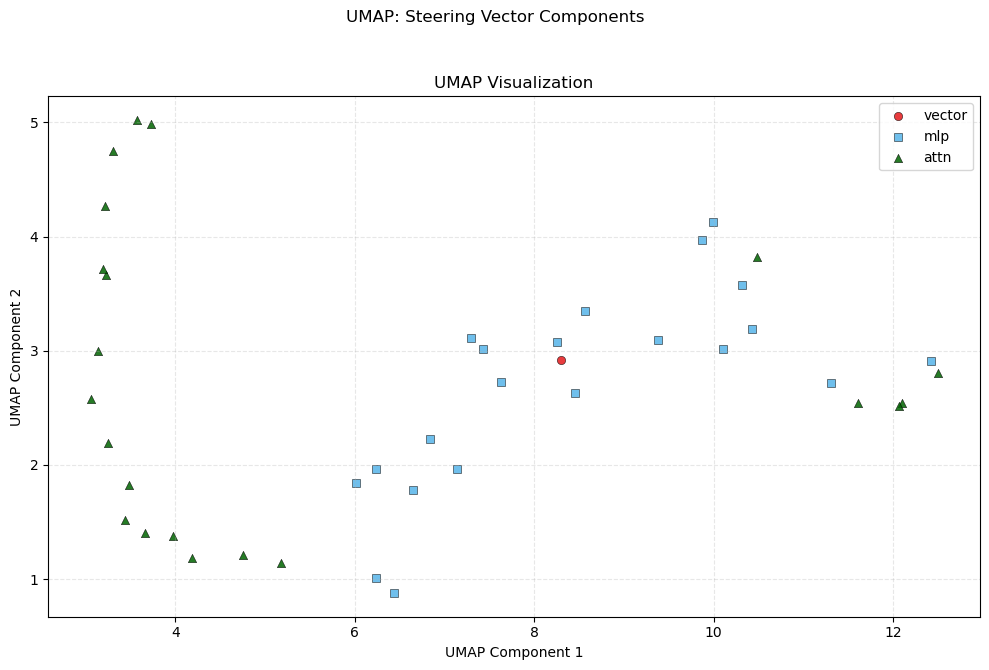

[[10.478883   3.821855 ]
 [12.092698   2.540174 ]
 [12.063926   2.513135 ]
 [12.494182   2.8067038]
 [11.610485   2.5440507]
 [ 3.4438398  1.5203182]
 [ 4.1910243  1.1833149]
 [ 3.975893   1.3787919]
 [ 3.1365724  2.9959242]
 [ 3.664715   1.4016023]
 [ 3.0547922  2.5808592]
 [ 3.4823267  1.8230709]
 [ 3.728719   4.986623 ]
 [ 3.25185    2.1907768]
 [ 3.5704055  5.0203233]
 [ 4.749553   1.2123154]
 [ 3.227237   3.6639369]
 [ 3.3013124  4.7504463]
 [ 3.1984663  3.719424 ]
 [ 5.174114   1.139491 ]
 [ 3.2194912  4.2666802]]
99
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


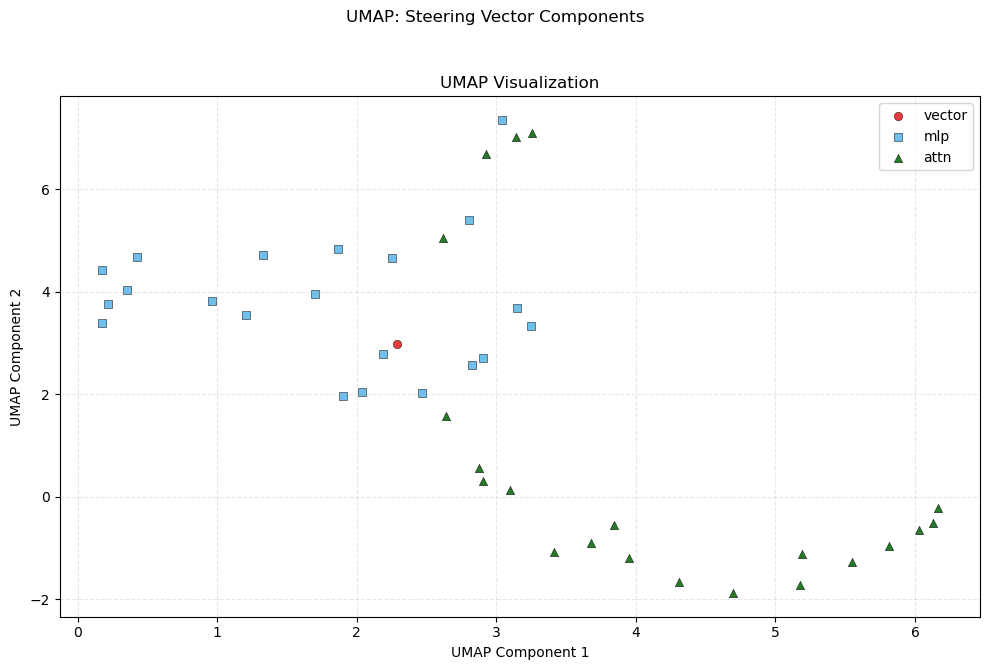

[[ 2.616554    5.0470977 ]
 [ 2.9287727   6.684236  ]
 [ 3.1399226   7.0275292 ]
 [ 3.4137743  -1.0682534 ]
 [ 3.258753    7.097125  ]
 [ 3.6822066  -0.90659684]
 [ 2.9078994   0.30295599]
 [ 3.1003108   0.12681253]
 [ 5.176583   -1.717227  ]
 [ 3.8407235  -0.5442537 ]
 [ 4.693091   -1.8769718 ]
 [ 3.9507995  -1.1939682 ]
 [ 6.1661143  -0.20770237]
 [ 4.3073826  -1.6555128 ]
 [ 6.1272116  -0.50815946]
 [ 2.8770185   0.56898946]
 [ 5.191475   -1.1064464 ]
 [ 6.0269375  -0.6397013 ]
 [ 5.547873   -1.2775869 ]
 [ 2.6378906   1.5717282 ]
 [ 5.813398   -0.94929034]]


In [16]:
rng = np.random.default_rng(42)

# for study_idx in range(len(gemma_2_data.keys())):
for idx, steering_vector in enumerate(gemma_2_data.keys()):
    # vector_idx = rng.choice(len(gemma_2_data.keys()), size=5, replace=False)
    # vectors = per_steering_vector[:, vector_idx, :]
    vectors = per_steering_vector[:, idx, :]
    print(steering_vector)
    X_tsne, X_umap = run_tsne_umap(vectors.reshape(vectors.shape[0], -1))
    create_graph(X_umap, id=steering_vector)
    print(X_umap[[i for i in range(1,len(X_umap),2)]])
